# Imports

In [1]:
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import os
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from trainer import MyTrainer
from models import *

# Checks for CUDA

In [2]:
print("Cuda available: " + str(torch.cuda.is_available()))
print("Cuda enabled: " + str(torch.backends.cudnn.enabled))

if torch.cuda.is_available():
    device = torch.device('cuda')

print("Compute device: " + str(device))

Cuda available: True
Cuda enabled: True
Compute device: cuda


# Path management

In [3]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.getcwd()

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# Data prep

#### Loads the data

In [4]:
train_path = get_full_dir("input/digit-recognizer/train.csv")
test_path = get_full_dir("input/digit-recognizer/test.csv")

In [5]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

#### Formats data

In [6]:
# Separates labels
x = df_train.drop(labels="label", axis=1)
y = df_train["label"]

#### Data overview

In [7]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


#### Reshapes

In [9]:
# Convert to numpy arrays
x = x.to_numpy()
y = y.to_numpy()
test_npa = df_test.to_numpy()

In [10]:
# Updates shape to match image size 28x28x1 (only one channel per image)
x = x.reshape(-1, 1, 28, 28)
test_npa = test_npa.reshape(-1, 1, 28, 28)

In [11]:
# Divides the train set to train and validation
X_train, X_dev, y_train, y_dev = train_test_split(x, y, test_size=0.2, random_state=8888)

In [12]:
# Defines augmentation transform
transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))
])

# Performs data augmentation

In [13]:
# Performs data augmentation
augmented_x_train = []
augmented_y_train = []
num_augmentations = 30

for x_a, y_a in zip(torch.tensor(X_train), y_train):
    for i in range(num_augmentations):
        augmented_x_train.append(transform(x_a))
        augmented_y_train.append(y_a)
    augmented_x_train.append(x_a)
    augmented_y_train.append(y_a)

#x = np.array(augmented_x)
# Convert each tensor to a numpy array
augmented_data_np = [x_t.numpy() for x_t in augmented_x_train]
# Concatenate all numpy arrays along the first axis
X_train = np.concatenate(augmented_data_np, axis=0)
X_train = X_train.reshape(-1, 1, 28, 28)

y_train = np.array(augmented_y_train)

In [14]:
augmented_x_dev = []
augmented_y_dev = []
num_augmentations = 30

for x_a, y_a in zip(torch.tensor(X_dev), y_dev):
    for i in range(num_augmentations):
        augmented_x_dev.append(transform(x_a))
        augmented_y_dev.append(y_a)
    augmented_x_dev.append(x_a)
    augmented_y_dev.append(y_a)

#x = np.array(augmented_x)
# Convert each tensor to a numpy array
augmented_data_np = [x_t.numpy() for x_t in augmented_x_dev]
# Concatenate all numpy arrays along the first axis
X_dev = np.concatenate(augmented_data_np, axis=0)
X_dev = X_dev.reshape(-1, 1, 28, 28)

y_dev = np.array(augmented_y_dev)

In [15]:
print("Train size: " + str(len(X_train)) + " Dev size: " + str(len(X_dev)))

Train size: 1041600 Dev size: 260400


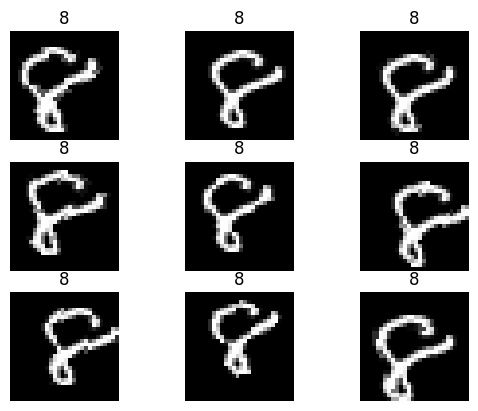

In [16]:
#train samples
for i in range(0, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title(y_train[i])

#### Converts data to tensors and normalize them

In [17]:
#train
X_train_tensor = torch.tensor(X_train)/255.0
y_train_tensor = torch.tensor(y_train)
train_tensor = TensorDataset(X_train_tensor, y_train_tensor)

#val
X_dev_tensor = torch.tensor(X_dev)/255.0
y_dev_tensor = torch.tensor(y_dev)
dev_tensor = TensorDataset(X_dev_tensor, y_dev_tensor)

#test
test_image_tensor = torch.tensor(test_npa)/255.0

#### Defines data loaders

In [18]:
train_loader = DataLoader(train_tensor, batch_size=64, num_workers=2, shuffle=True)
dev_loader = DataLoader(dev_tensor, batch_size=64, num_workers=2, shuffle=True)
test_loader = DataLoader(test_image_tensor, batch_size=64, num_workers=2, shuffle=False)

# Train the model

In [19]:
ensemble_size = 11

In [20]:
for i in range(0, ensemble_size):
    print("-------------------------------[MyConNet6_{} train start]--------------------------------".format(i))
    model = MyConNet6()
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.5)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5)
    trainer = MyTrainer(model, optimizer, loss_function, lr_scheduler)

    if torch.cuda.is_available():
        model = model.cuda()
        loss_function = loss_function.cuda()

    trainer.fit(train_loader, dev_loader, epochs=5, eval_every=1, sub_epoch_logs=True, sub_epoch_percentile=0.05)

    torch.save(model.state_dict(), "models/MyConNet6_" + str(i) + ".pt")
    print("--------------------------------[MyConNet6_{} train end]---------------------------------".format(i))

-------------------------------[MyConNet6_0 train start]--------------------------------
Current learning rate: [0.002]
Train Epoch: 0 [208320/1041600 (20%)]		Loss: 0.649567
Train Epoch: 0 [416640/1041600 (40%)]		Loss: 0.174610
Train Epoch: 0 [624960/1041600 (60%)]		Loss: 0.121068
Train Epoch: 0 [833280/1041600 (80%)]		Loss: 0.094502
Train Epoch: 0 [1041600/1041600 (100%)]		Loss: 0.081287
Train Epoch: 0 Average Loss: 0.224207

The loss after 1 epochs was 0.0321 

Current learning rate: [0.001]
Train Epoch: 1 [208320/1041600 (20%)]		Loss: 0.065724
Train Epoch: 1 [416640/1041600 (40%)]		Loss: 0.062810
Train Epoch: 1 [624960/1041600 (60%)]		Loss: 0.055900
Train Epoch: 1 [833280/1041600 (80%)]		Loss: 0.054237
Train Epoch: 1 [1041600/1041600 (100%)]		Loss: 0.052012
Train Epoch: 1 Average Loss: 0.058137

The loss after 2 epochs was 0.0227 

Current learning rate: [0.0005]
Train Epoch: 2 [208320/1041600 (20%)]		Loss: 0.045204
Train Epoch: 2 [416640/1041600 (40%)]		Loss: 0.043366
Train Epoch: 

# Make predictions on the test set

In [21]:
model_predictions = []

def make_predictions(eval_model, data_loader):
    eval_model.eval()
    if torch.cuda.is_available():
        eval_model = eval_model.cuda()
    test_predictions = torch.LongTensor().cuda()

    for batch_idx, data in enumerate(data_loader):
        if torch.cuda.is_available():
            data = data.cuda()

        output = eval_model(data)
        predictions = torch.max(output, dim=1)[1]
        test_predictions = torch.cat((test_predictions, predictions), dim=0)

    return np.asarray(test_predictions.cpu())

for i in range(0, ensemble_size):
    model = MyConNet6()
    model.load_state_dict(torch.load("models/MyConNet6_" + str(i) + ".pt"))
    model_predictions.append(make_predictions(model, test_loader))

In [22]:
np.asarray(model_predictions).T

array([[2, 2, 2, ..., 2, 2, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [9, 9, 9, ..., 9, 9, 9],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [9, 9, 9, ..., 9, 9, 9],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int64)

In [23]:
finale_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=np.asarray(model_predictions))
submissions = pd.DataFrame({"ImageId": list(range(1,len(finale_predictions.squeeze())+1)),"Label": finale_predictions})
submissions

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [24]:
pd.DataFrame(submissions).to_csv("submission.csv", index=False, header=True)